In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/sample.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv


# Predicting Recipe Ratings: A Data Science Approach:
In this project, we aimed to develop predictive models for estimating the ratings of recipes based on user comments and other metadata. Our objective was to leverage machine learning algorithms to accurately predict recipe ratings, which could be valuable for recipe platforms in recommending high-quality recipes to users. We started by exploring and pre-processing the dataset, which involved data cleaning, feature engineering, and text pre-processing techniques such as removing punctuation and numerical values from user comments. Then we implemented various machine learning models, including LightGBM, XGBoost, SVM, Randomforest, KNN and LogisticRegressionCV to train and evaluate their performance in predicting recipe ratings. The analysis revealed that the LightGBM model achieved the highest accuracy and F1 score among the models evaluated, with an accuracy of 78.58%. The ROC-AUC curve analysis indicated that the model performed well in distinguishing between different rating classes, particularly for higher-rated recipes. However, some classes, such as class 5, showed lower AUC scores, suggesting room for improvement in predicting ratings for certain recipes. Overall, our project demonstrates the effectiveness of machine learning algorithms in predicting recipe ratings based on user comments and metadata. The models developed could be integrated into recipe platforms to provide users with personalized recommendations and enhance their culinary experience.

# Goal:
To build models that can predict the ratings for each recipe given.
# Description of columns:
* RecipeNumber: order at which recipes are ranked in the top 100
* Recipe Name: name of the recipe
* RecipeCode:Unique ID of the recipe used by the site
* CommentID: Unique ID of the comment
* UserID: Unique ID of the user who left the comment
* UserName: Name of the user
* UserReputation: Internal score of the site, roughly quantifying the past behavior of the user
* CreationTimestamp: Time at which the comment was posted
* ReplyCount: Number of replies to the comment
* ThumbsUpCount: Number of up-votes the comment has received
* ThubsDownCount: Number of down-votes the comment has received
* Rating:score on a scale of 1 to 5 that the user gave to the recipe, score of 0 means that no score was given
* BestScore: Score of the comment
* Recipe_Review: Text content of the comment

# Importing all the necessary libraries

In [2]:
# importing libraries
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')
from scipy.stats import chi2_contingency
from sklearn.metrics import precision_score, recall_score
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_regression, mutual_info_regression
import string
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier 
from sklearn.neighbors import KNeighborsClassifier

# Loading the dataset

In [3]:
train=pd.read_csv('/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv')
test=pd.read_csv('/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv')

# Baseline Model

In [5]:
# X=train.drop(columns=['Rating'])
# y=train['Rating']
# dummy_clf = DummyClassifier(strategy="most_frequent")
# dummy_clf.fit(X, y)
# DummyClassifier(strategy='most_frequent')
# dummy_clf.predict(X)
# dummy_clf.score(X, y)
# y_pred=dummy_clf.predict(test)
# y_pred
# ID=[i for i in range(1,4547)]
# sub=pd.DataFrame(ID, columns=['ID'])
# sub=pd.DataFrame(y_pred, columns=['Rating'])
# sub_rating=y_pred
# sub.index.name='ID'
# sub.to_csv('submission.csv',encoding='utf-8', index='False')
# output=pd.read_csv('submission.csv')

0.7605602816075095

In [7]:
#train.shape

In [6]:
# train.head()
# train.shape
# train.describe()
# train['RecipeNumber'].nunique()
# train['RecipeCode'].nunique()
# train['RecipeName'].nunique()
# #train['CommentID'].nunique() 
# train['UserID'].nunique() 
#train['UserName'].nunique() 
# train['UserReputation'].nunique()
# train['CreationTimestamp'].nunique()
# train['Recipe_Review'].nunique()
# train['RecipeCode'].nunique()

# **Exploratory Data Analysis**
* > **Understanding the statistics , types of each feature, checking for missing values.
* > ** Divided the object type features to cat_cols and int type features to num_cols

In [7]:
# ## EDA##
# ##BASICS

train.info()
num_cols = train.select_dtypes(include=['int', 'float']).columns.tolist()
print(num_cols)
cat_cols=train.select_dtypes(include=['object']).columns.tolist()
cat_cols
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13636 entries, 0 to 13635
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 13636 non-null  int64 
 1   RecipeNumber       13636 non-null  int64 
 2   RecipeCode         13636 non-null  int64 
 3   RecipeName         13636 non-null  object
 4   CommentID          13636 non-null  object
 5   UserID             13636 non-null  object
 6   UserName           13636 non-null  object
 7   UserReputation     13636 non-null  int64 
 8   CreationTimestamp  13636 non-null  int64 
 9   ReplyCount         13636 non-null  int64 
 10  ThumbsUpCount      13636 non-null  int64 
 11  ThumbsDownCount    13636 non-null  int64 
 12  Rating             13636 non-null  int64 
 13  BestScore          13636 non-null  int64 
 14  Recipe_Review      13634 non-null  object
dtypes: int64(10), object(5)
memory usage: 1.6+ MB
['ID', 'RecipeNumber', 'RecipeCode', 'Use

,ID,RecipeNumber,RecipeCode,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore
count,13636.000000,13636.000000,13636.000000,13636.000000,1.363600e+04,13636.000000,13636.000000,13636.000000,13636.000000,13636.000000
mean,121.085289,38.624377,21785.990833,2.160311,1.623713e+09,0.014520,1.098269,0.543708,4.288721,153.127897
std,116.995633,29.672351,23883.189918,10.086424,5.444020e+06,0.137323,4.166487,3.265660,1.544839,140.986908
min,0.000000,1.000000,386.000000,0.000000,1.613035e+09,0.000000,0.000000,0.000000,0.000000,0.000000
25%,45.000000,12.000000,6504.000000,1.000000,1.622717e+09,0.000000,0.000000,0.000000,5.000000,100.000000
50%,91.000000,33.000000,14600.000000,1.000000,1.622718e+09,0.000000,0.000000,0.000000,5.000000,100.000000
75%,148.000000,63.000000,33121.000000,1.000000,1.622718e+09,0.000000,0.000000,0.000000,5.000000,100.000000
max,724.000000,100.000000,191775.000000,510.000000,1.665756e+09,3.000000,80.000000,126.000000,5.000000,946.000000


1. # **This bar graph plots the unique number of values in the numerical features.**


ID                    701
RecipeNumber          100
RecipeCode            100
UserReputation         20
CreationTimestamp    2422
ReplyCount              4
ThumbsUpCount          57
ThumbsDownCount        51
Rating                  6
BestScore             525
dtype: int64


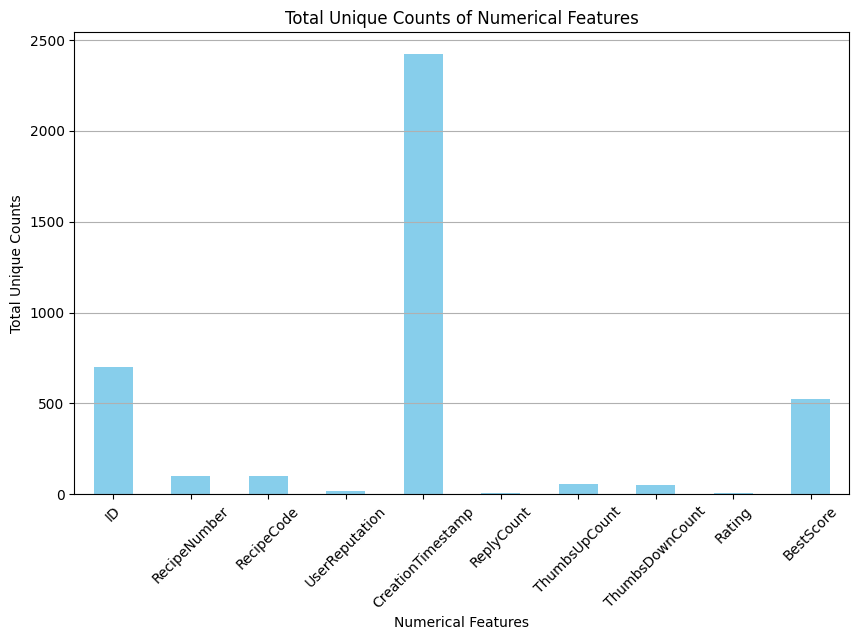

In [8]:
unique_value_counts = pd.DataFrame(columns=num_cols)
total_unique_counts = train[num_cols].nunique()
print(total_unique_counts)
plt.figure(figsize=(10, 6))
total_unique_counts.plot(kind='bar', color='skyblue')
plt.title('Total Unique Counts of Numerical Features')
plt.xlabel('Numerical Features')
plt.ylabel('Total Unique Counts')
plt.xticks(rotation=45)
plt.grid(axis='y')

# 2. **KDE PLOTS PROVIDES A SMOOTH DISTRIBUTION OF THE DATA**
* 1.ID: is right skewed and more values are concentrated at the lower end and has a longer tail towards higher values.
* 2.Recipe Number:is right skewed 
* 3.RecipeCode:is right skewed and bimodal distribution and has outliers at the lower end.
* 4.UserReputation & CreationTimestamp:Both are right skewed and more values concentrated at lower end.
* 6.ReplyCount: It is righ skewed and has longer tail till 3 in the x axis.
* 7.ThumbsUpCount & ThumbsDownCount:Both are right skewed as their data start from 0 and has a longer tail towards the higher values
* 8.Rating:It is left skewed and has outliers towrads the lowest ratings
* 9.BestScore:It is right skewed and has small clusters/ outliers.

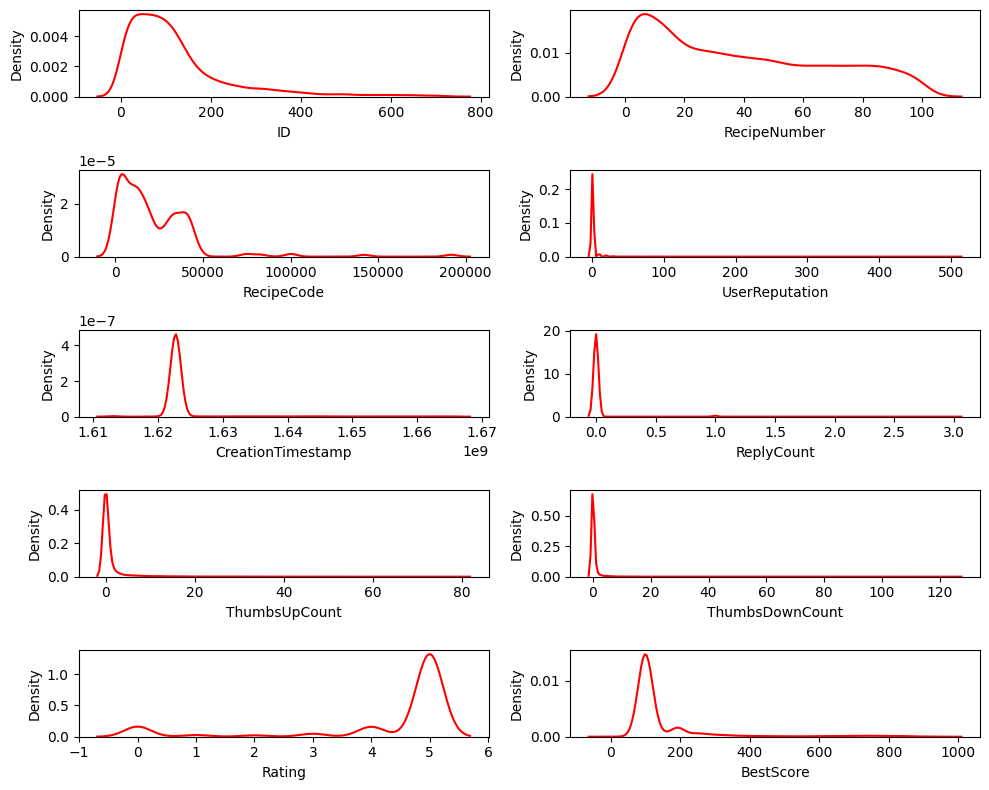

In [9]:
# ##Univariate Analysis
plt.figure(figsize=(10,8))
plt.title('Analysis for numerical columns', fontsize=24)
num_row=5
num_col=2
for i in range (0,len(num_cols)):
    plt.subplot(num_row, num_col, i+1)
    sns.kdeplot(x=train[num_cols[i]], color='red')
    plt.xlabel(num_cols[i])
plt.tight_layout()
plt.show()

# 3. **CHI-SQUARE TEST**
* > Null Hypothesis: There is no relationship between categorical and target variable i.e Rating.
* > Alternate Hypothesis: There is  a relationship between categorical and target variable i.e Rating.
* > Here Reject  means the null hypothesis is rejected at a significance level of 0.05. This suggests a statistically significant association between the categorical variable and the rating.
* > Accept means the null hypothesis is not rejected. There is insufficient evidence to conclude a significant relationship between the categorical variable and the rating.

* 
> 0     RecipeName  Reject
> 1      CommentID  Accept
> 2         UserID  Reject
> 3       UserName  Reject
> 4  Recipe_Review  Reject


In [10]:
# ##CHI-SQ TEST 
# ##null:no relation between cat and target
# ##alt: relation between cat and target
chi_test = []

for i in cat_cols:
    contingency_table = pd.crosstab(train['Rating'], train[i])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    if p_value < 0.05:
        chi_test.append('Reject')
    else:
        chi_test.append('Accept')
result=pd.DataFrame(data=[cat_cols, chi_test]).T
result.columns=['Feature Name','Results']
print(result)
    

    Feature Name Results
0     RecipeName  Reject
1      CommentID  Accept
2         UserID  Reject
3       UserName  Reject
4  Recipe_Review  Reject


# 4. **CORRELATION MATRIX FOR NUMERICAL VALUES**
> * We see a very strong positive correlation between Creation Time Stamp and Thumbs Up Count with Best Score.
> * Also we see a strong negative correlation between Recipe Number and BestScore with ID

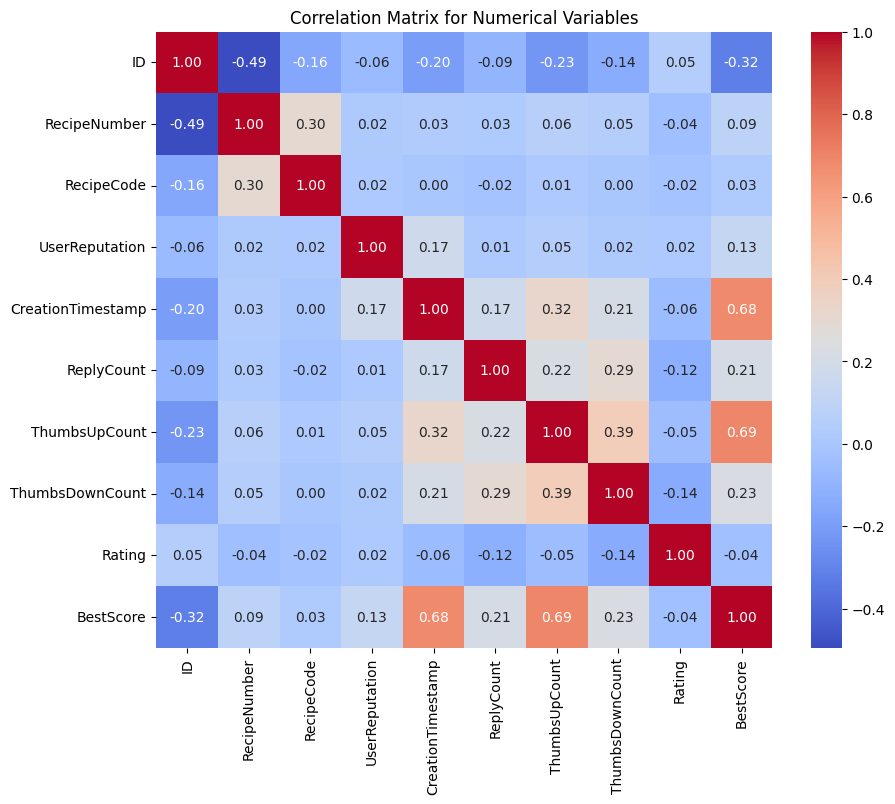

In [11]:
# Creating a DataFrame containing only numerical columns
numerical_df = train[num_cols]

# Calculating the correlation matrix
corr_mat = numerical_df.corr()

# Displaying the correlation matrix
#print(correlation_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix for Numerical Variables")
plt.show()




# 5. Scatter Plots****
# * **Scatter plot between Creation Time Stamp and Best Score**
    We see a positive correlation but as well there are outliers which fall from the main cluster. This could imply that newer comments tend to be more relevant i.e comments posted later (higher CreationTimestamp values).
# * **Scatter plot between Thumbs Up Count and Best Score**
    We see two clusters,  the comments in cluster1 are perceived as less valuable or relevant by users, resulting in lower score. The other cluster comments seems more popular or positively received by users compared to those in Cluster 1.
# * **Scatter plot between Recipe Number and Best Score**
    The dense pattern observed across the Recipe Numbers suggests that recipes tend to receive a wide range of Best Scores ranging from 100-400. Later we see a small dense pattern over the  lower Recipe Numbers suggests that recipes ranked higher on the list (with lower Recipe Numbers) have more better Best Scores.


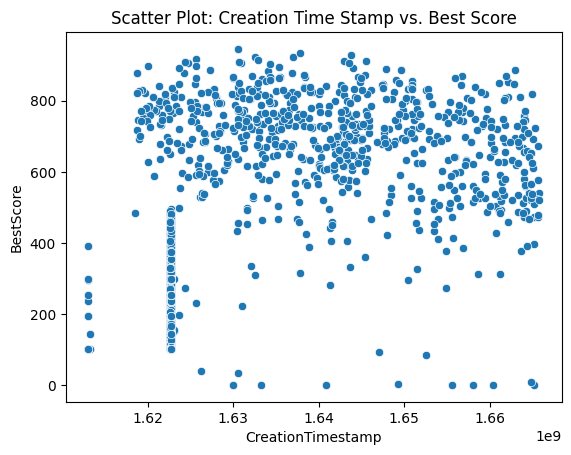

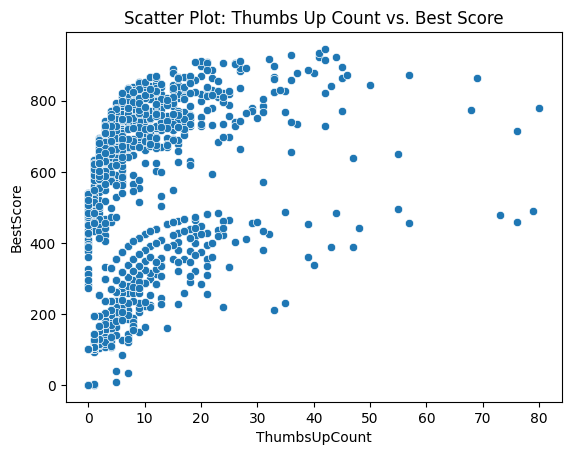

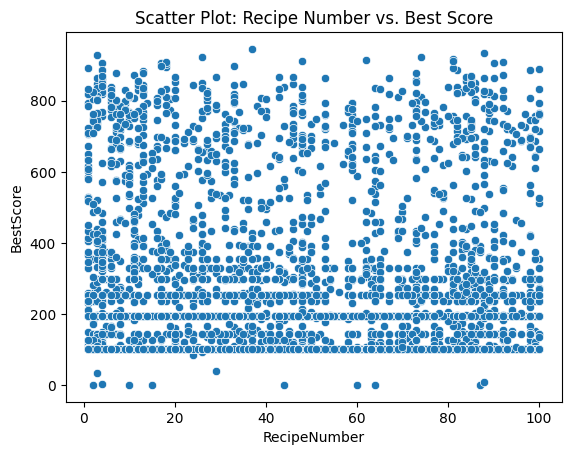

In [12]:
# Scatter plot between Creation Time Stamp and Best Score
sns.scatterplot(data=train, x='CreationTimestamp', y='BestScore')
plt.title('Scatter Plot: Creation Time Stamp vs. Best Score')
plt.show()

# Scatter plot between Thumbs Up Count and Best Score
sns.scatterplot(data=train, x='ThumbsUpCount', y='BestScore')
plt.title('Scatter Plot: Thumbs Up Count vs. Best Score')
plt.show()

# Scatter plot between Recipe Number and Best Score
sns.scatterplot(data=train, x='RecipeNumber', y='BestScore')
plt.title('Scatter Plot: Recipe Number vs. Best Score')
plt.show()


# **Deriving new features from Creation Time Stamp**

In [8]:
train['DateTime'] = pd.to_datetime(train['CreationTimestamp'], unit='s')
train['Month'] = train['DateTime'].dt.month_name()
train['Hour'] = train['DateTime'].dt.hour
train['Weekday'] = train['DateTime'].dt.day_name()
test['DateTime'] = pd.to_datetime(test['CreationTimestamp'], unit='s')
test['Month'] = test['DateTime'].dt.month_name()
test['Hour'] = test['DateTime'].dt.hour
test['Weekday'] = test['DateTime'].dt.day_name()
train.head()


,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Recipe_Review,DateTime,Month,Hour,Weekday
0,70,71,12259,Banana Bars with Cream Cheese Frosting,sp_aUSaElGf_12259_c_149978,u_1oKVaBmiEKwAFyiHrDLoWpbel0J,misscoffeepot,20,1622717078,0,0,0,5,100,great recipe! I have made them just as written...,2021-06-03 10:44:38,June,10,Thursday
1,72,88,8202,Simple Taco Soup,sp_aUSaElGf_8202_c_310332,u_1oKZeRIXYzGNhGW8OMR3O4lX1ih,MichelleMalone,1,1622717852,0,0,1,5,100,This is an easy and quick recipe that is great...,2021-06-03 10:57:32,June,10,Thursday
2,458,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_206522,u_1oKYHUtdaD48KJCDYq5wfpAUxWz,jeannem32,1,1622717357,0,0,0,3,100,I think I was looking for something extra spec...,2021-06-03 10:49:17,June,10,Thursday
3,7,50,100276,Grilled Huli Huli Chicken,sp_aUSaElGf_100276_c_434088,u_1oKZCQcKQZdQhDVBS7oISc216VA,ds422,1,1622648899,0,0,0,5,100,This is our favorite grilled chicken recipe. ...,2021-06-02 15:48:19,June,15,Wednesday
4,60,12,19731,Cauliflower Soup,sp_aUSaElGf_19731_c_387011,u_1oKd4sudZQPgu6YALiC7bW7mKMs,SusanHoward,1,1622718260,0,0,0,4,100,Great basic recipe. I added 2 teaspoons Tuscan...,2021-06-03 11:04:20,June,11,Thursday


# **Removing features with low importance**
* Recipe Code, Recipe Name, User Name, UserID, CommentID were unique identifiers and might have led to overfitting.
* Excluded the original CreationTimestamp and DateTime features from the final model as features Month, Hour, Weekday were derived from the CreationTimeStamps which were used for the model building.

In [9]:
columns_to_drop = ['RecipeCode','RecipeName', 'UserName', 'UserID','CommentID', 'ThumbsDownCount','CreationTimestamp', 'DateTime']
train=train.drop(columns=columns_to_drop)
test=test.drop(columns=columns_to_drop)

**> ****** As there were only 2 missing values in Recipe_Review, opted to remove those two rows.********

In [10]:
train.isnull().sum()
test.isnull().sum()
train=train.dropna()
train.isnull().sum()
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13634 entries, 0 to 13635
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              13634 non-null  int64 
 1   RecipeNumber    13634 non-null  int64 
 2   UserReputation  13634 non-null  int64 
 3   ReplyCount      13634 non-null  int64 
 4   ThumbsUpCount   13634 non-null  int64 
 5   Rating          13634 non-null  int64 
 6   BestScore       13634 non-null  int64 
 7   Recipe_Review   13634 non-null  object
 8   Month           13634 non-null  object
 9   Hour            13634 non-null  int32 
 10  Weekday         13634 non-null  object
dtypes: int32(1), int64(7), object(3)
memory usage: 1.2+ MB


# **Numerical columns:** 
* ID : is a unique identifier which had unique values of 701.
* From the scatter plot we observed that Best Score had certain influence with Thumbs Up Count and Recipe Number, also  it represents the score of the comment, to determine the order comments appear in.
* Reply Count is the number of replies to a comment which could indicate the engagement level of users with the recipe. 
* User Reputation: users with higher reputation scores might be seen as more credible or experienced, affecting their ratings.
# **Categorical columns:**
* Recipe Number: The placement of the recipe on the top 100 list might affect its visibility and thus its rating.
* Month, Hour, Weekday are features derived from Creation Time Stamp which can lead to shows some trends.
# **Text Column:**
* Recipe_Review contains the text content of the comment which needs to be further pre processed.


# **Splitting of Data**

In [12]:
X,y= train.drop(columns=['Rating']), train['Rating']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
numerical_cols=['ID','UserReputation','ReplyCount','ThumbsUpCount','BestScore']
categorical_cols=['RecipeNumber','Month','Hour','Weekday']
text_cols=['Recipe_Review']

**SelectKBest**
* It will help in reducing the dimensionality of the dataset by retaining only the most informative features.

In [13]:
from sklearn.feature_selection import SelectKBest, chi2, f_regression, mutual_info_regression
Num_df = X_train[numerical_cols]
chi2_features = SelectKBest(chi2, k=2)
X_best = chi2_features.fit_transform(Num_df, y_train)
chi2_features.get_support()



array([ True, False, False, False,  True])

# Pipelines
* Numerical Pipeline selects the most relevant features and normalize them using StandardScaler.
* Categorical Features encodes them into one-hot vectors using OneHotEncoder.
* Text Features converts them into a numerical representation using TF-IDF.


In [15]:
##pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
num_pipe=Pipeline([('feature_selection', SelectKBest(chi2, k=2)), ('scaler',StandardScaler())])
cat_pipe=Pipeline([('Encode',OneHotEncoder(handle_unknown='ignore'))])
text_pipe=Pipeline([('Tfidf',TfidfVectorizer(stop_words='english'))])
Transformer=ColumnTransformer([('num_pipe',num_pipe,numerical_cols),('cat_pipe',cat_pipe,categorical_cols)])#, remainder='passthrough')

# Text Preprocessing:
> 1. Removes punctuation

In [17]:
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])#i iterates over each character in the text checks whether if it is not a punctuation then join all the non punctuation characters together in the new string 'punctuationstring'
    return punctuationfree #returns modified text which is punctuation free 
train["Recipe_Review"]= train["Recipe_Review"].apply(lambda x:remove_punctuation(x))#applying'remove_punctuation' to each element in Recipe_Review column of training dataset using lambda function
test["Recipe_Review"]= test["Recipe_Review"].apply(lambda x:remove_punctuation(x))##applying'remove_punctuation' to each element in Recipe_Review column of test dataset using lambda function

> 2.Removes words with fewer than 3 characters and numeric characters. 

In [18]:
def dataPreprocessing(text):
    flag = False#set boolean variable to False
    new_text = [] #empty list
    for j in text.split(" "): #splits the words in text using the space as delimiter and iterates over j
        word = j.strip() #removes leading and trailing whitespace from word in j and assigns to word
        if len(word) > 3 and j.isnumeric() == False:  #checks if the cleaned'word' has length greater than 3 characters and if original word(before cleaned) doesn't entirely consist of  entirely numeric characters
            for k in j: #iterates over each character k in the original word j
                if k.isnumeric(): #checks if it is numeric
                    flag = True #if numeric sets flag to True 
                    break
            if flag == False: # no numeric character found in original word j 
                new_text.append(word)  #append the cleaned 'word' to new_text
        flag = False #resets the flag to false for next iteration
    return " ".join(new_text) #joins the elements of the new_text into a single string separated by spaces
train["Recipe_Review"] = train["Recipe_Review"].apply(lambda x:dataPreprocessing(x)) #applied the function to the elements of text column of train dataset
test["Recipe_Review"] = test["Recipe_Review"].apply(lambda x:dataPreprocessing(x)) #applied the function to the elements of text column of test dataset

In [19]:
def train_transform(X_train, y_train, Transformer, pipeline): # function with 4 arguments
    x1=Transformer.fit_transform(X_train, y_train).todense() # transforms the numerical and categorical features using the specified transformer and converts the result into a dense matrix.
    x2=pipeline.fit_transform(X_train['Recipe_Review'],y_train).todense() #transforms the text data using text preprocessing steps TF-IDF vectorization and converts the result into a dense matrix.
    X_transformed=np.concatenate((x1,x2), axis=1)#concatenates the transformed numerical features x1 and text features x2, to create the final transformed feature matrix X_transformed.
    return X_transformed


In [22]:
def test_transform(X_test, Transformer, pipeline):
    x1=Transformer.transform(X_test).todense() ## transforms the numerical and categorical features using the specified transformer and converts the result into a dense matrix.
    x2=pipeline.transform(X_test['Recipe_Review']).todense() #transforms the text data using text preprocessing steps TF-IDF vectorization and converts the result into a dense matrix.
    X_test_transformed=np.concatenate((x1,x2), axis=1)##concatenates the transformed numerical features x1 and text features x2, to create the final transformed feature matrix X_transformed.
    return X_test_transformed


X_train_transformed = train_transform(X_train, y_train, Transformer, text_pipe)

In [24]:
X_test_transformed = test_transform(X_test, Transformer, text_pipe)

In [25]:
#from sklearn.decomposition import PCA

# Instantiate PCA with the desired number of components
#pca = PCA(n_components=2)

# Fit PCA on the transformed data
#X_train_transformed_pca = pca.fit_transform(np.asarray(X_train_transformed))

# Transform the test data
#X_test_transformed_pca = pca.transform(np.asarray(X_test_transformed))

In [26]:
#from sklearn.decomposition import TruncatedSVD

# Instantiate TruncatedSVD
#svd = TruncatedSVD(n_components=2, random_state=42)

# Fit and transform the training data
#X_train_transformed_svd = svd.fit_transform(np.asarray(X_train_transformed))

# Transform the test data
#X_test_transformed_svd = svd.transform(np.asarray(X_test_transformed))


# Model 1: LightGBM
* LGBoost Accuracy: 0.7858452511917858
* F1 Score: 0.7343416537585575
* LGB Precision Score: 0.7299834536114213
* LGB Recall Score: 0.7858452511917858


In [25]:
# lgb_model = LGBMClassifier(random_state=100)
# lgb_model.fit(np.asarray(X_train_transformed), y_train)
# lgb_predictions = lgb_model.predict(np.asarray(X_test_transformed))
# lgb_prob = lgb_model.predict_proba(np.asarray(X_test_transformed))
# lgb_pred_prob = lgb_prob[:, 1]
# lgb_accuracy = accuracy_score(y_test, lgb_predictions)
# print("LGBoost Accuracy:", lgb_accuracy)
# lgb_f1 = f1_score(y_test, lgb_predictions, average='weighted')
# print("F1 Score:",lgb_f1)
# lgb_precision = precision_score(y_test, lgb_predictions, average='weighted')
# lgb_recall = recall_score(y_test, lgb_predictions,average='weighted')
# print("LGB Precision Score:", lgb_precision)
# print("LGB Recall Score:", lgb_recall)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 45654
[LightGBM] [Info] Number of data points in the train set: 10907, number of used features: 1320
[LightGBM] [Info] Start training from score -2.355970
[LightGBM] [Info] Start training from score -4.167261
[LightGBM] [Info] Start training from score -4.399320
[LightGBM] [Info] Start training from score -3.627279
[LightGBM] [Info] Start training from score -2.396429
[LightGBM] [Info] Start training from score -0.274717
LGBoost Accuracy: 0.7858452511917858
F1 Score: 0.7343416537585575
LGB Precision Score: 0.7299834536114213
LGB Recall Score: 0.7858452511917858


# Model 2: XGBoostClassifier
* XGBoost Accuracy: 0.7799779977997799
* F1 Score: 0.7126270039342988
* XGB Precision Score: 0.7258708059503135
* XGB Recall Score: 0.7799779977997799


In [48]:
# xgb_model = XGBClassifier(random_state=100)
# xgb_model.fit(np.asarray(X_train_transformed), y_train)
# xgb_predictions = xgb_model.predict(np.asarray(X_test_transformed))
# xgb_prob = xgb_model.predict_proba(np.asarray(X_test_transformed))
# xgb_pred_prob = xgb_prob[:, 1]
# xgb_accuracy = accuracy_score(y_test, xgb_predictions)
# print("XGBoost Accuracy:", xgb_accuracy)
# xgb_f1 = f1_score(y_test, xgb_predictions, average='weighted')
# print("F1 Score:", xgb_f1)
# xgb_precision = precision_score(y_test, xgb_predictions,average='weighted')
# print("XGB Precision Score:", xgb_precision)
# xgb_recall = recall_score(y_test, xgb_predictions,average='weighted')
# print("XGB Recall Score:", xgb_recall)

XGBoost Accuracy: 0.7799779977997799
F1 Score: 0.7126270039342988
XGB Precision Score: 0.7258708059503135
XGB Recall Score: 0.7799779977997799


# Model 3: SVM
* SVM Accuracy Score: 0.7788778877887789
* SVM F1 Score: 0.7361654951388363
* SVM Precision Score: 0.7272589244539687
* SVM Recall Score: 0.7788778877887789


In [49]:
# svm_model = SVC(kernel='rbf', C=10, gamma='scale',probability=True)
# svm_model.fit(np.asarray(X_train_transformed), y_train)
# svm_pred = svm_model.predict(np.asarray(X_test_transformed))
# svm_prob = svm_model.predict_proba(np.asarray(X_test_transformed))
# svm_pred_prob = svm_prob[:, 1]
# svm_accuracy = accuracy_score(y_test, svm_pred)
# print("SVM Accuracy:", svm_accuracy)
# svm_f1 = f1_score(y_test, svm_pred, average='weighted')
# print("F1 Score:",svm_f1)
# svm_precision= precision_score(y_test, svm_pred,average='weighted')
# print("SVM Precision Score:", svm_precision)
# svm_recall = recall_score(y_test, svm_pred,average='weighted')
# print("SVM Recall Score:", svm_recall)

SVM Accuracy: 0.7788778877887789
F1 Score: 0.7361654951388363
SVM Precision Score: 0.7272589244539687
SVM Recall Score: 0.7788778877887789


# Model 4: Random Forest Classifier
* Random Forest Accuracy: 0.7708104143747708
* F1 Score: 0.6810094608052856
* RF Precision Score: 0.7565027055651814
* RF Recall Score: 0.7708104143747708


In [46]:
# rf_model = RandomForestClassifier()
# rf_model.fit(np.asarray(X_train_transformed), y_train)
# rf_predictions = rf_model.predict(np.asarray(X_test_transformed))
# rf_prob = rf_model.predict_proba(np.asarray(X_test_transformed))
# rf_pred_prob = rf_prob[:, 1]
# rf_accuracy = accuracy_score(y_test, rf_predictions)
# print("Random Forest Accuracy:", rf_accuracy)
# rf_f1 = f1_score(y_test, rf_predictions, average='weighted')
# print("F1 Score:", rf_f1)
# rf_precision = precision_score(y_test, rf_predictions,average='weighted')
# print("RF Precision Score:", rf_precision)
# rf_recall = recall_score(y_test, rf_predictions,average='weighted')
# print("RF Recall Score:", rf_recall)

Random Forest Accuracy: 0.7711771177117712
F1 Score: 0.682464024842778
RF Precision Score: 0.7544601334703208
RF Recall Score: 0.7711771177117712


# Model 5: LogisticRegressionCV
* Logistic Regression Accuracy: 0.7697103043637697
* F1 Score: 0.6835155296869914
* LR Precision Score: 0.6828643285309003
* LR Recall Score: 0.7697103043637697

In [50]:
# lr = LogisticRegressionCV(cv=5, random_state=0)
# lr.fit(np.asarray(X_train_transformed), y_train)
# lr_predictions = lr.predict(np.asarray(X_test_transformed))
# lr_prob = lr.predict_proba(np.asarray(X_test_transformed))
# lr_pred_prob = lr_prob[:, 1]
# lr_accuracy = accuracy_score(y_test, lr_predictions)
# print("Logistic Regression Accuracy:", lr_accuracy)
# lr_f1 = f1_score(y_test, lr_predictions, average='weighted')
# print("F1 Score:", lr_f1)
# lr_precision = precision_score(y_test, lr_predictions,average='weighted')
# print("LR Precision Score:", lr_precision)
# lr_recall = recall_score(y_test, lr_predictions,average='weighted')
# print("LR Recall Score:", lr_recall)# 

# Evaluate the model
#print(classification_report(y_test, y_pred))

Logistic Regression Accuracy: 0.7697103043637697
F1 Score: 0.6835155296869914
LR Precision Score: 0.6828643285309003
LR Recall Score: 0.7697103043637697


XGBClassifier HPT

In [32]:
# #Define the parameter grid
# param_grid = {
#    'n_estimators': [100, 200, 300],  # Number of trees
#    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate
#    'max_depth': [3, 4, 5],  # Maximum depth of each tree
#     'subsample': [0.7, 0.8, 0.9],  # Subsample ratio of the training instances
#     'colsample_bytree': [0.7, 0.8, 0.9]  # Subsample ratio of columns when constructing each tree
# }
# #Create XGBoost classifier
# xgb_model = XGBClassifier(random_state=42)
# #Instantiate GridSearchCV
# grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy')
# #Fit the search object to the training data
# grid_search.fit(np.asarray(X_train_transformed), y_train)
# #Access the best parameters
# xgb_best_params = grid_search.best_params_
# print("Best hyperparameters:", best_params)
# #Predict on the test data using the best model
# xgb_y_pred = grid_search.predict(np.asarray(X_test_transformed))
# #Evaluate the model
# xgb_gscv_accuracy = accuracy_score(y_test, xgb_y_pred)
# print("Accuracy:", xgb_gscv_accuracy)

**KNeighborsClassifier HPT**
* Best parameters obtained:n_neighbors=9, weights=distance, metric=euclidean


In [33]:
# param_grid = {
#     'n_neighbors': [3, 5, 7, 9],  # Number of neighbors to consider
#     'weights': ['uniform', 'distance'],  # Weighting scheme for neighbors
#     'metric': ['euclidean', 'manhattan']  # Distance metric
# }
# knn = KNeighborsClassifier()
# grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy')
# grid_search.fit(np.asarray(X_train_transformed), y_train)
# knn_best_params = grid_search.best_params_
# print("Best hyperparameters:", best_params)
# best_knn = grid_search.best_estimator_

**Model 6:KNeighborsClassifier**
* Accuracy: 0.7627429409607628
* F1 Score: 0.6844669603140856
* KNN Precision Score: 0.6687212029544846
* KNN Recall Score: 0.7627429409607628


In [47]:
# knn = KNeighborsClassifier(metric= 'euclidean', n_neighbors= 9, weights= 'distance')
# knn.fit(np.asarray(X_train_transformed), y_train)
# knn_pred = knn.predict(np.asarray(X_test_transformed))
# knn_prob = knn.predict_proba(np.asarray(X_test_transformed))
# knn_pred_prob = knn_prob[:, 1]
# knn_accuracy = accuracy_score(y_test, knn_pred)
# print("Accuracy:", knn_accuracy)
# knn_f1 = f1_score(y_test, knn_pred, average='weighted')
# print("F1 Score:", knn_f1)
# knn_precision = precision_score(y_test, knn_pred,average='weighted')
# print("KNN Precision Score:", knn_precision)
# knn_recall = recall_score(y_test, knn_pred,average='weighted')
# print("KNN Recall Score:", knn_recall)
# # #{'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}

Accuracy: 0.7627429409607628
F1 Score: 0.6844669603140856
KNN Precision Score: 0.6687212029544846
KNN Recall Score: 0.7627429409607628


In [35]:
# submission=pd.DataFrame(columns=['ID','Rating'])
# submission['ID']=[i for i in range(1,len(lgb_predictions)+1)]
# submission['Rating']=lgb_predictions
# submission.to_csv('submission.csv', index=False)

SVC HPT


In [36]:
# param_grid = {
#    'C': [0.1, 1, 10],
#    'kernel': ['linear', 'rbf', 'poly'],
#    'gamma': ['scale', 'auto']
# }
# svc_model = SVC()
# grid_search = GridSearchCV(svc_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
# grid_search.fit(np.asarray(X_train_transformed), y_train)
# print("Best Parameters:", grid_search.best_params_)
# best_svc = grid_search.best_estimator_
# svc_y_pred = best_svc.predict(np.asarray(X_test_transformed))
# #print(classification_report(y_test, svc_y_pred))
# svc_accuracy = accuracy_score(y_test, svc_y_pred)
# print("Accuracy:", svc_accuracy)
# svc_f1 = f1_score(y_test, svc_y_pred, average='weighted')
# print("F1 Score:", svc_f1)

# EVALUATION OF THE MODELS
1. The bar graph plots the Precision score of the models


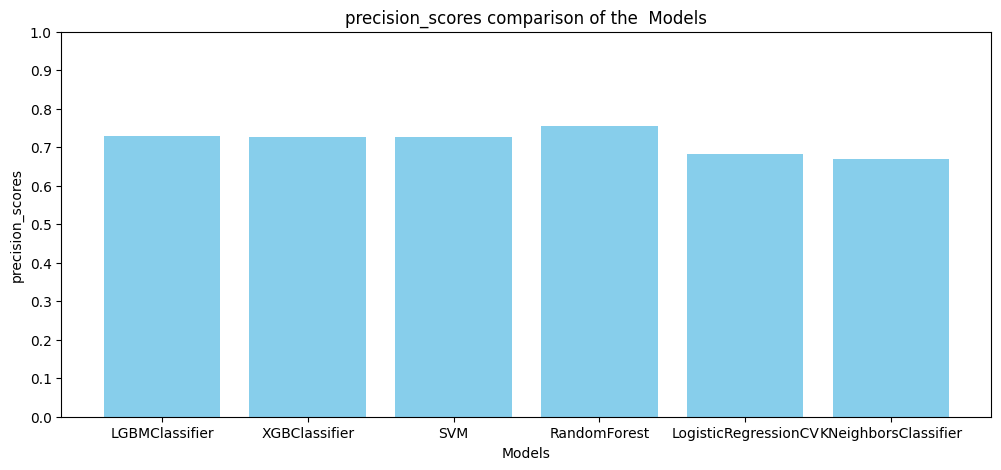

In [61]:
# Models=['LGBMClassifier','XGBClassifier','SVM','RandomForest','LogisticRegressionCV','KNeighborsClassifier']
# precision_scores=[lgb_precision,xgb_precision,svm_precision,rf_precision, lr_precision, knn_precision  ]
# plt.figure(figsize=(12, 5))
# plt.bar(Models, precision_scores, color='skyblue')
# plt.xlabel('Models')
# plt.ylabel('precision_scores')
# plt.title('precision_scores comparison of the  Models')
# plt.ylim(0, 1)
# plt.yticks([i/10 for i in range(11)])
# plt.show()

2. The bar graph plots the recall score of the models 

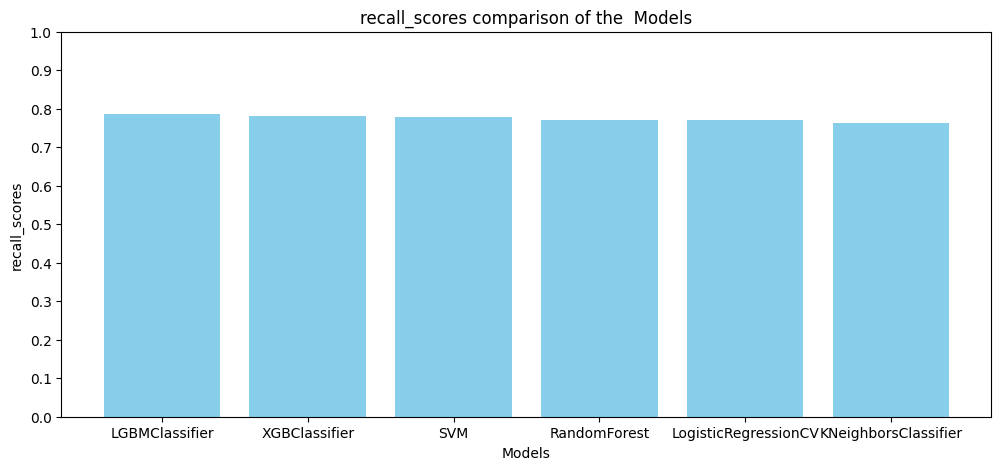

In [60]:
# Models=['LGBMClassifier','XGBClassifier','SVM','RandomForest','LogisticRegressionCV','KNeighborsClassifier']
# recall_scores=[lgb_recall,xgb_recall,svm_recall,rf_recall, lr_recall, knn_recall  ]
# plt.figure(figsize=(12, 5))
# plt.bar(Models, recall_scores, color='skyblue')
# plt.xlabel('Models')
# plt.ylabel('recall_scores')
# plt.title('recall_scores comparison of the  Models')
# plt.ylim(0, 1)
# plt.yticks([i/10 for i in range(11)])# Set y-axis limits to 0-1
# plt.show()


3. The bar graph plots the F1_Score of the models

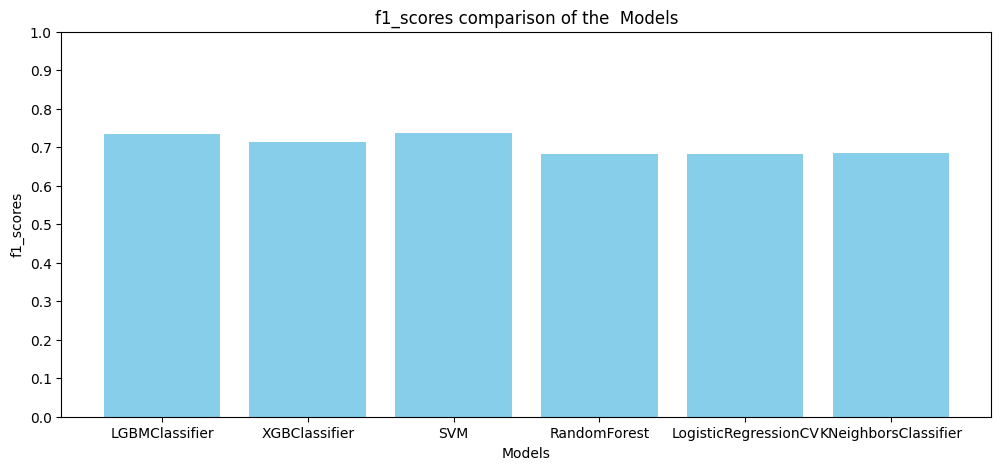

In [59]:
# Models=['LGBMClassifier','XGBClassifier','SVM','RandomForest','LogisticRegressionCV','KNeighborsClassifier']
# f1_scores=[lgb_f1,xgb_f1,svm_f1,rf_f1,lr_f1,knn_f1]
# plt.figure(figsize=(12, 5))
# plt.bar(Models, f1_scores, color='skyblue')
# plt.xlabel('Models')
# plt.ylabel('f1_scores')
# plt.title('f1_scores comparison of the  Models')
# plt.ylim(0, 1) 
# plt.yticks([i/10 for i in range(11)])# Set y-axis limits to 0-1
# plt.show()

4. The bar graph plots the Accuracy of the models

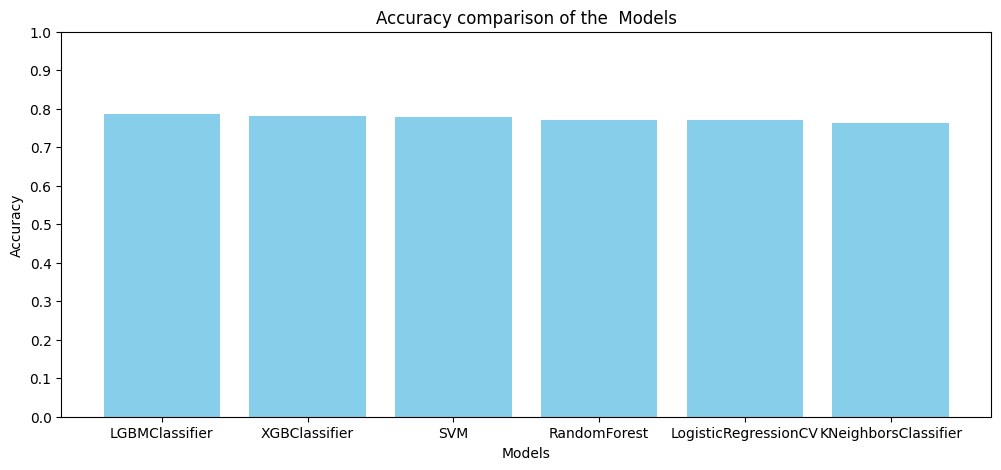

In [58]:
# Models=['LGBMClassifier','XGBClassifier','SVM','RandomForest','LogisticRegressionCV','KNeighborsClassifier']
# Accuracy=[lgb_accuracy,xgb_accuracy,svm_accuracy,rf_accuracy, lr_accuracy, knn_accuracy   ]
# plt.figure(figsize=(12, 5))
# plt.bar(Models, Accuracy, color='skyblue')
# plt.xlabel('Models')
# plt.ylabel('Accuracy')
# plt.title('Accuracy comparison of the  Models')
# plt.ylim(0, 1)
# plt.yticks([i/10 for i in range(11)])# Set y-axis limits to 0-1
# plt.show()

5. ROC_AUC Curve of LightGBM classifier(Model 1)
* Class 1 has the highest AUC score (0.93), implying excellent performance.
* Class 2 and 3 also have relatively high AUC scores (0.89 and 0.73), implying good performance.
* Class 0 and 4 have lower AUC scores (0.62 and 0.59), implying moderate performance.
* Class 5 has the lowest AUC score (0.31), implying poor performance for its corresponding class.


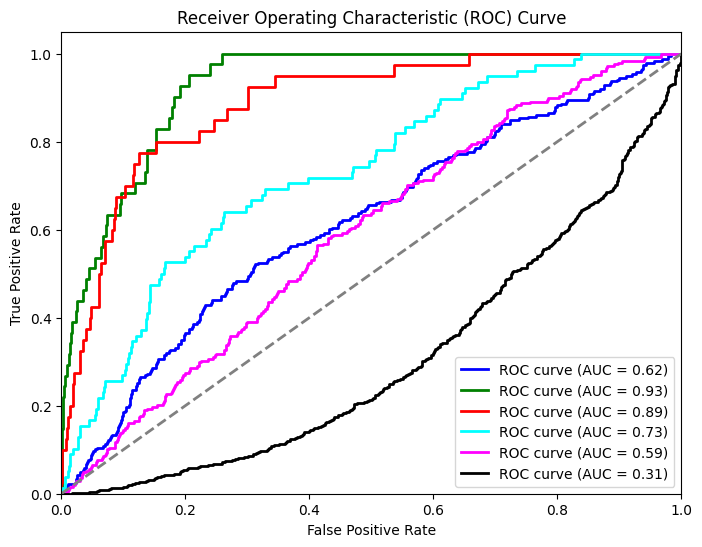

In [64]:
# from sklearn.preprocessing import label_binarize
# from sklearn.metrics import roc_curve, roc_auc_score
# import matplotlib.pyplot as plt
# y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
# num_classes = len(np.unique(y_test))
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(num_classes):
#     fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], lgb_pred_prob)
#     roc_auc[i] = roc_auc_score(y_test_bin[:, i], lgb_pred_prob)
# plt.figure(figsize=(8, 6))
# colors = ['blue', 'green', 'red', 'cyan', 'magenta','black']
# for i, color in zip(range(num_classes), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc[i])
# plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc='lower right')
# plt.show()


6. ROC_AUC Curve of XGBoost classifier(Model 2)
* Class 1 has the highest AUC score (0.90), implying excellent performance.
* Class 2 and 3 also have relatively high AUC scores (0.86 and 0.73), implying good performance.
* Class 0 and 4 have lower AUC scores (0.63 and 0.58), implying moderate performance.
* Class 5 has the lowest AUC score (0.31), implying poor performance for its corresponding class.

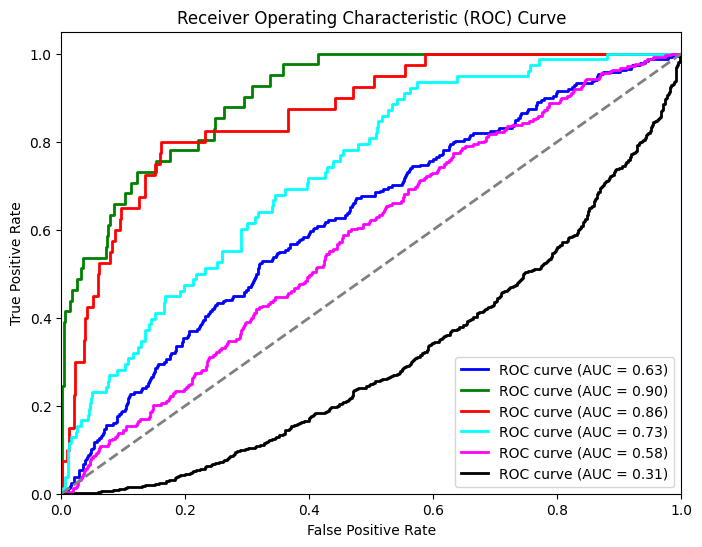

In [65]:
# y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(num_classes):
#     fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], xgb_pred_prob)
#     roc_auc[i] = roc_auc_score(y_test_bin[:, i], xgb_pred_prob)
# plt.figure(figsize=(8, 6))
# colors = ['blue', 'green', 'red', 'cyan', 'magenta','black'] 
# for i, color in zip(range(num_classes), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc[i])
# plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc='lower right')
# plt.show()


7. ROC_AUC Curve of SVM classifier(Model 4)
* Class 1,  2 and 3 also have relatively high AUC scores (0.87, 0.78 and 0.71), implying good performance.
* Class 4 and 0 have lower AUC scores (0.55 and 0.54), implying moderate performance.
* Class 5 has the lowest AUC score (0.38), implying poor performance for its corresponding class.

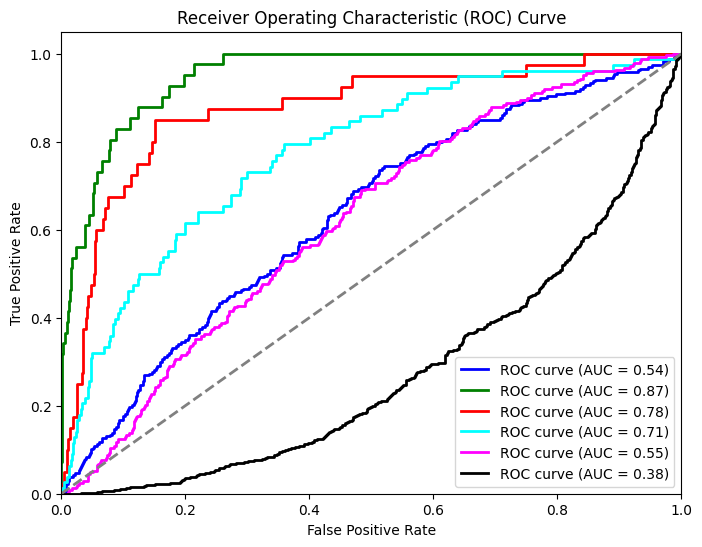

In [69]:
# y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(num_classes):
#     fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], svm_pred_prob)
#     roc_auc[i] = roc_auc_score(y_test_bin[:, i], svm_pred_prob)
# plt.figure(figsize=(8, 6))
# colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'black']  # You can customize colors
# for i, color in zip(range(num_classes), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc[i])
# plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc='lower right')
# plt.show()

